## Import Required Libraries

In [1]:
import os
import numpy as np
import re
import random
import pickle
from email import policy
from email.parser import BytesParser
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, Embedding, SpatialDropout1D, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Set the environment variable to suppress TensorFlow warnings
print("TF version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

TF version: 2.10.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Load and Preprocess Dataset

### Preprocess and Load Email Functions

In [2]:
# Safely get text from email parts
def safe_get_text(part):
    try:
        return part.get_content()
    except LookupError:
        raw = part.get_payload(decode=True) or b''
        # Try declared charset, else utf-8, then latin-1
        charset = part.get_content_charset() or 'utf-8'
        try:
            return raw.decode(charset, errors='ignore')
        except (LookupError, UnicodeDecodeError):
            return raw.decode('latin-1', errors='ignore')

# Replace links with <URL> in the text
def replace_links(text):
    # Pattern for http(s):// or www. links
    text = re.sub(r'https?://\S+|www\.\S+', '<URL>', text)
    # Pattern for bare domains like example.com/path
    text = re.sub(
        r'\b[\w.-]+\.(com|org|net|edu|gov|io|co)(/[^\s]*)?\b',
        '<URL>',
        text
    )
    return text

# Extract email text from the message
def extract_email_text(msg):
    parts = []
    # Subject
    if msg['Subject']:
        parts.append(str(msg['Subject']))
    # Body (plain + HTML, cleaned)
    for part in msg.walk():
        content_type = part.get_content_type()
        if content_type == 'text/plain':
            parts.append(safe_get_text(part))
        elif content_type == 'text/html':
            html = safe_get_text(part)
            soup = BeautifulSoup(html, "html.parser")
            parts.append(soup.get_text())
    # Join, lowercase, clean up whitespace
    text = ' '.join(parts).lower()
    text = re.sub(r"\s+", " ", text)

    # Replace links with <URL>
    text = replace_links(text)
    
    return text.strip()

# Load emails from a folder and assign a label
def load_emails(folder, label):
    texts, labels = [], []
    for fname in os.listdir(folder):
        path = os.path.join(folder, fname)
        with open(path, 'rb') as f:
            msg = BytesParser(policy=policy.default).parse(f)
        # Use the improved extraction function!
        text = extract_email_text(msg)
        texts.append(text)
        labels.append(label)
    return texts, labels



### Load Dataset

In [3]:
# Load normal and spam emails
X_norm, y_norm = load_emails('data/normal', 0)
X_spam, y_spam = load_emails('data/spam', 1)
X = X_norm + X_spam
y = np.array(y_norm + y_spam)

### Split Dataset

In [4]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,        # 80/20 split
    stratify=y,           # preserve spam∶ham ratio
    random_state=42
)

## Finding Optimal Tokenizer Parameters

In [ ]:
# Fit a full tokenizer just to inspect raw training data
full_tokenizer = Tokenizer(oov_token="<OOV>")
full_tokenizer.fit_on_texts(X_train)

# Find the number of unique tokens
true_vocab_size = len(full_tokenizer.word_index)
print("Total unique tokens in train:", true_vocab_size)

# Find distribution of sequence lengths
seqs   = full_tokenizer.texts_to_sequences(X_train)
lengths = [len(s) for s in seqs]
for p in [50, 75, 90, 95, 99]:
    print(f"{p}th percentile length:", np.percentile(lengths, p))

# Find the number of words that cover 90% of all tokens
word_counts  = full_tokenizer.word_counts
total_tokens = sum(word_counts.values())
cumulative   = 0
for i, (_, cnt) in enumerate(word_counts.items(), 1):
    cumulative += cnt
    if cumulative / total_tokens > 0.90:
        print(f"{i} words cover 90% of all tokens")
        break


Total unique tokens in train: 54033
50th percentile length: 159.0
75th percentile length: 286.0
90th percentile length: 580.4000000000005
95th percentile length: 990.1999999999998
99th percentile length: 2684.879999999992
12062 words cover 90% of all tokens


## Model Training

### Configure Model

In [6]:
# Use the 90th percentile length as the max_len and the number of words that cover 90% of all tokens as max_words
max_words = 12000
max_len = 600

# Compute class weights
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight = {0: weights[0], 1: weights[1]}
print(class_weight)  

# Tokenize the text
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Save the tokenizer for later use
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Load the tokenizer from the file
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

# Define the model
# Use a Sequential model
inp = Input((max_len,))
x = Embedding(max_words, 128, input_length=max_len)(inp)
x = SpatialDropout1D(0.3)(x)

# Conv1D layer with reduced units
x = Conv1D(64, 5, activation='relu', kernel_regularizer=l2(1e-3))(x)
x = GlobalMaxPooling1D()(x)

# Dense layer with reduced units
x = Dense(64, activation='relu', kernel_regularizer=l2(1e-3))(x)
x = Dropout(0.5)(x)

out = Dense(1, activation='sigmoid')(x)

# Compile the model
model = Model(inp, out)
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(1e-4),
    metrics=['accuracy']
)

# Show the model summary
model.summary()


{0: 0.7217592592592592, 1: 1.6273486430062631}
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 600)]             0         
                                                                 
 embedding (Embedding)       (None, 600, 128)          1536000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 600, 128)         0         
 ropout1D)                                                       
                                                                 
 conv1d (Conv1D)             (None, 596, 64)           41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)

### Model Training

In [7]:
# Early stopping and training
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    class_weight=class_weight
)

Epoch 1/50
147/147 [==============================] - 9s 19ms/step - loss: 0.8275 - accuracy: 0.4836 - val_loss: 0.8100 - val_accuracy: 0.7179
Epoch 2/50
147/147 [==============================] - 2s 15ms/step - loss: 0.7778 - accuracy: 0.7156 - val_loss: 0.7390 - val_accuracy: 0.8957
Epoch 3/50
147/147 [==============================] - 2s 14ms/step - loss: 0.6825 - accuracy: 0.8450 - val_loss: 0.6018 - val_accuracy: 0.9154
Epoch 4/50
147/147 [==============================] - 2s 14ms/step - loss: 0.5285 - accuracy: 0.9081 - val_loss: 0.4380 - val_accuracy: 0.9385
Epoch 5/50
147/147 [==============================] - 2s 15ms/step - loss: 0.4050 - accuracy: 0.9354 - val_loss: 0.3508 - val_accuracy: 0.9496
Epoch 6/50
147/147 [==============================] - 2s 14ms/step - loss: 0.3235 - accuracy: 0.9457 - val_loss: 0.2966 - val_accuracy: 0.9573
Epoch 7/50
147/147 [==============================] - 2s 14ms/step - loss: 0.2744 - accuracy: 0.9570 - val_loss: 0.2565 - val_accuracy: 0.9650

## Model Evaluation

### Find Best Threshold Value

In [8]:
# Get predicted probabilities for the test set
y_probs = model.predict(X_test_pad).flatten()

# Try many thresholds and find the best for F1-score
thresholds = np.arange(0.1, 0.91, 0.01)
best_f1 = 0
best_thresh = 0.5

for thresh in thresholds:
    y_pred = (y_probs > thresh).astype(int)
    f1 = f1_score(y_test, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh

print(f"Best threshold: {best_thresh:.2f} with F1-score: {best_f1:.4f}")

# Detailed report at the best threshold
y_pred_best = (y_probs > best_thresh).astype(int)
print(classification_report(y_test, y_pred_best, target_names=['Ham', 'Spam']))


37/37 [==============================] - 0s 2ms/step
Best threshold: 0.62 with F1-score: 0.9708
              precision    recall  f1-score   support

         Ham       0.99      0.99      0.99       810
        Spam       0.97      0.97      0.97       360

    accuracy                           0.98      1170
   macro avg       0.98      0.98      0.98      1170
weighted avg       0.98      0.98      0.98      1170



### Confusion Matrix

37/37 [==============================] - 0s 4ms/step
Confusion Matrix:
 [[800  10]
 [ 11 349]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9864    0.9877    0.9870       810
           1     0.9721    0.9694    0.9708       360

    accuracy                         0.9821      1170
   macro avg     0.9793    0.9785    0.9789      1170
weighted avg     0.9820    0.9821    0.9820      1170



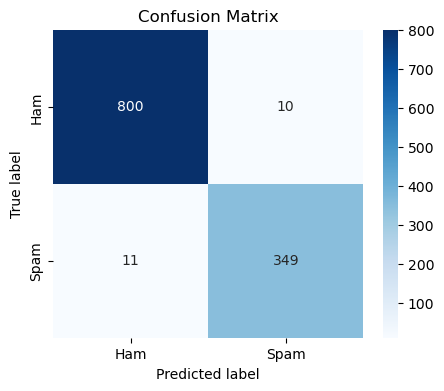

In [9]:
# Get raw probabilities
y_pred_prob = model.predict(X_test_pad).ravel()

# Apply that threshold (instead of hard-coded 0.5)
y_pred = (y_pred_prob > best_thresh).astype(int)

# Confusion matrix & report
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))

# Plot the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham','Spam'], yticklabels=['Ham','Spam'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()


## Dump Model

In [10]:
model.save('spam_cnn_saved_model')

INFO:tensorflow:Assets written to: spam_cnn_saved_model\assets


INFO:tensorflow:Assets written to: spam_cnn_saved_model\assets
